In [26]:
from datetime import date
import datetime
from datetime import datetime  
from datetime import timedelta  
import dateutil.parser
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [27]:
data = pd.read_csv(r'C:\Users\JMSch\Desktop\COVID19\Netherlands_29032020.csv', sep = ',')

## Remove the dates of which no infections were reported
data = data[data.Confirmed != 0]

## Assign a t value to each date from the first reported infection
data.insert(loc=0, column='Time', value=np.arange(len(data))+1)

## Transform the date from Excel numbers to Python dates
data['Date'] = data['Date'].apply(lambda x: x -2)
data['Date'] = data['Date'].astype('datetime64[D]') 
data['Date'] = data['Date'].dt.strftime('%d/%m/2020')

In [28]:
data['logConfirmed'] = np.log(data.Confirmed)

In [29]:
today = date.today()
## Selecting the timeframe for building the regression
LastWeek = today - timedelta(days=7) 
LastWeek = LastWeek.strftime("%d/%m/%Y")

RowIndex = int(data.index[data['Date'] == LastWeek].tolist()[0])
## find time of index RowIndex
TimeIndex = data.at[RowIndex, 'Time']
Data_New = data[TimeIndex:]

In [30]:
X = Data_New.Time
X = sm.add_constant(X)

y = Data_New.logConfirmed

mod = sm.OLS(y, X)
res = mod.fit()
results_summary = res.summary()
print(res.summary())


OLS Regression Results                            
Dep. Variable:           logConfirmed   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 29 Mar 2020   Prob (F-statistic):                nan
Time:                        21:45:16   Log-Likelihood:                 58.734
No. Observations:                   2   AIC:                            -113.5
Df Residuals:                       0   BIC:                            -116.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2683        inf          0        nan         nan         nan
T

In [31]:
## This code transforms the regression coefficients into floats to use in our prediction function
results_as_html = results_summary.tables[1].as_html()
New_DF = pd.read_html(results_as_html, header=0, index_col=0)[0]

Constant_Coefficient = New_DF.at['const','coef']
Time_Coeffificient = New_DF.at['Time','coef']

In [32]:
def linear_predictions(t):
    return np.exp(Constant_Coefficient) * np.exp(Time_Coeffificient) ** t

In [33]:
Current_Horizon = int(max(data['Time']))
Prediction_Horizon = 14 ##Change "14" to adjust the forecasting horizon
FindDate = data['Date'].iloc[-1]
MaxDate = dateutil.parser.parse(FindDate).date()

columns = ['Time', 'Date']
for i in range(Prediction_Horizon):
    New_Time = max(data['Time']) + 1
    Days_Delay = (New_Time - Current_Horizon)
    New_Date = MaxDate + timedelta(days=Days_Delay) 
    New_Date = New_Date.strftime("%d/%m/%Y")
    data = data.append({'Time': New_Time, 'Date': New_Date},ignore_index=True)


In [34]:
data['Predictions'] = data.Time.apply(linear_predictions)

In [35]:
data.to_csv(r'C:\Users\JMSch\Desktop\COVID19\COVID19_Netherlands_29032020.csv', index = False)

No handles with labels found to put in legend.


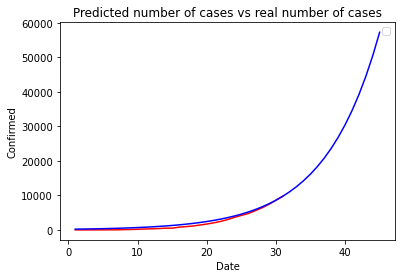

In [36]:
plt.plot(data.Time, data.Confirmed, 'red')
plt.plot(data.Time, data.Predictions, 'blue')
plt.title('Predicted number of cases vs real number of cases')
plt.xlabel('Date')
plt.ylabel('Confirmed')
plt.legend()